In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/deep-learning-spring-2025-project-1/cifar_test_nolabel.pkl
/kaggle/input/deep-learning-spring-2025-project-1/cifar-10-python/cifar-10-batches-py/data_batch_1
/kaggle/input/deep-learning-spring-2025-project-1/cifar-10-python/cifar-10-batches-py/data_batch_2
/kaggle/input/deep-learning-spring-2025-project-1/cifar-10-python/cifar-10-batches-py/batches.meta
/kaggle/input/deep-learning-spring-2025-project-1/cifar-10-python/cifar-10-batches-py/test_batch
/kaggle/input/deep-learning-spring-2025-project-1/cifar-10-python/cifar-10-batches-py/data_batch_3
/kaggle/input/deep-learning-spring-2025-project-1/cifar-10-python/cifar-10-batches-py/data_batch_5
/kaggle/input/deep-learning-spring-2025-project-1/cifar-10-python/cifar-10-batches-py/data_batch_4
/kaggle/input/deep-learning-spring-2025-project-1/cifar-10-python/cifar-10-batches-py/readme.html


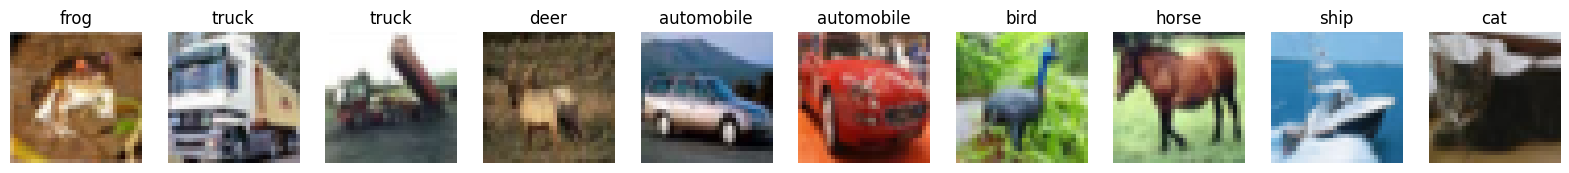

In [3]:
def load_cifar_batch(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

# Specify the folder where the CIFAR-10 batch files are
cifar10_dir = '/kaggle/input/deep-learning-spring-2025-project-1/cifar-10-python/cifar-10-batches-py'

# Load the label names
meta_data_dict = load_cifar_batch(os.path.join(cifar10_dir, 'batches.meta'))
label_names = meta_data_dict[b'label_names']

train_images = []
train_labels = []
data_batches = ['data_batch_1', 'data_batch_2', 'data_batch_3', 'data_batch_4', 'data_batch_5']
for batch in data_batches:
    # Load one batch for demonstration (e.g., data_batch_1)
    batch_dict = load_cifar_batch(os.path.join(cifar10_dir, batch))
    train_images.append(batch_dict[b'data'])
    train_labels.append(batch_dict[b'labels'])

train_images = np.concatenate((train_images[0], train_images[1], train_images[2], train_images[3], train_images[4]))
train_labels = np.concatenate((train_labels[0], train_labels[1], train_labels[2], train_labels[3], train_labels[4]))

# Reshape the images
train_images = train_images.reshape((50000, 3, 32, 32)).transpose(0, 2, 3, 1)


# Display the first 10 images and labels
plt.figure(figsize=(20, 4))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(train_images[i])
    plt.title(label_names[train_labels[i]].decode('utf-8'))  # Decoding from bytes to string
    plt.axis('off')
plt.show()

In [4]:
# Read the test file, note that it has no labels and needs to be used with your model inference to predict outputs.

def load_cifar_batch(file):
    with open(file, 'rb') as fo:
        batch = pickle.load(fo, encoding='bytes')
    return batch

# Load the batch
cifar10_batch = load_cifar_batch('/kaggle/input/deep-learning-spring-2025-project-1/cifar_test_nolabel.pkl')

# Extract images 
test_images = cifar10_batch[b'data']
# Unlike the train images you are not required to reshape to (number of images, width, height, channels) 
# as the test data is already in (N x W x H x C) format

In [23]:
# Load the batch
validation_data = load_cifar_batch('/kaggle/input/deep-learning-spring-2025-project-1/cifar-10-python/cifar-10-batches-py/test_batch')

# Extract images 
validation_images = validation_data[b'data']
validation_labels = validation_data[b'labels']

validation_images = validation_images.reshape((10000, 3, 32, 32)).transpose(0, 2, 3, 1)

# Unlike the train images you are not required to reshape to (number of images, width, height, channels) 
# as the test data is already in (N x W x H x C) format

NameError: name 'images' is not defined

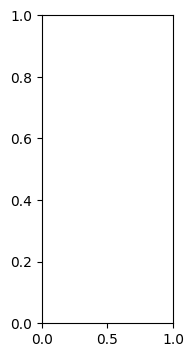

In [5]:
# Display the first 10 images
plt.figure(figsize=(20, 4))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(images[i])
    plt.axis('off')
plt.show()

In [6]:
class BuildingBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BuildingBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.relu2 = nn.ReLU()

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = self.relu1(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = self.relu2(out)
        return out

In [7]:
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)


    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(BuildingBlock(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


In [8]:
def ResNet18():
    return ResNet(BuildingBlock, [2, 1, 1, 1])

device = "cuda" if torch.cuda.is_available() else "cpu"
model = ResNet18()
model = model.to(device)
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
              ReLU-5           [-1, 64, 32, 32]               0
            Conv2d-6           [-1, 64, 32, 32]          36,864
       BatchNorm2d-7           [-1, 64, 32, 32]             128
              ReLU-8           [-1, 64, 32, 32]               0
     BuildingBlock-9           [-1, 64, 32, 32]               0
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
             ReLU-12           [-1, 64, 32, 32]               0
           Conv2d-13           [-1, 64, 32, 32]          36,864
      BatchNorm2d-14           [-1, 64,

In [24]:
train_dataset = [(img, label) for img, label in zip(train_images, train_labels)]
validation_dataset = [(img, label) for img, label in zip(validation_images, validation_labels)]

trainDataLoader = torch.utils.data.DataLoader(train_dataset,batch_size=64,shuffle=True)

validationDataLoader = torch.utils.data.DataLoader(validation_dataset,batch_size=64,shuffle=True)

testDataLoader = torch.utils.data.DataLoader(test_images,batch_size=64,shuffle=False)

In [10]:
!pip install tqdm

In [31]:
from tqdm import tqdm

loss = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

train_loss_history = []
test_loss_history = []

num_epochs = 100

for epoch in tqdm(range(num_epochs)):
  train_loss = 0.0
  test_loss = 0.0

  model.train()
  for i, data in enumerate(trainDataLoader):
    images, labels = data
    images = images.to(device)
    images = torch.tensor(images, dtype=torch.float32)  # Convert NumPy array to PyTorch tensor
    images = images.permute(0, 3, 1, 2)
    labels = labels.to(device)
    optimizer.zero_grad() # zero out any gradient values from the previous iteration
    predicted_output = model(images) # forward propagation
    predicted = torch.argmax(predicted_output, dim=1)
    correct += (predicted == labels).sum().item()  # Count correct predictions
    total += labels.size(0)  # Total number of samples
    fit = loss(predicted_output, labels)  # calculate our measure of goodness
    fit.backward() # backpropagation
    optimizer.step() # update the weights of our trainable parameters
    train_loss += fit.item()

  accuracy = 100 * correct / total  # Compute accuracy percentage
  print(f'Train Accuracy: {accuracy:.2f}%')

  correct = 0
  total = 0
  model.eval()
  for i, data in enumerate(validationDataLoader):
    with torch.no_grad():
      images, labels = data
      images = images.to(device)
      images = torch.tensor(images, dtype=torch.float32)  # Convert NumPy array to PyTorch tensor
      images = images.permute(0, 3, 1, 2)
      labels = labels.to(device)
      predicted_output = model(images)
      predicted = torch.argmax(predicted_output, dim=1)
      correct += (predicted == labels).sum().item()  # Count correct predictions
      total += labels.size(0)  # Total number of samples
      fit = loss(predicted_output, labels)
      test_loss += fit.item()
  train_loss = train_loss / len(trainDataLoader)
  test_loss = test_loss / len(testDataLoader)
  train_loss_history += [train_loss]
  test_loss_history += [test_loss]
  accuracy = 100 * correct / total  # Compute accuracy percentage
  print(f'Test Accuracy: {accuracy:.2f}%')
  print(f'Epoch {epoch}, Train loss {train_loss}, Test loss {test_loss}')
    

  0%|          | 0/100 [00:00<?, ?it/s]<ipython-input-31-bf53d8b0d55b>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  images = torch.tensor(images, dtype=torch.float32)  # Convert NumPy array to PyTorch tensor


Train Accuracy: 91.41%


<ipython-input-31-bf53d8b0d55b>:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  images = torch.tensor(images, dtype=torch.float32)  # Convert NumPy array to PyTorch tensor
  1%|          | 1/100 [00:51<1:25:30, 51.82s/it]

Test Accuracy: 69.63%
Epoch 0, Train loss 0.18664580714100462, Test loss 1.160504339986546
Train Accuracy: 92.44%


  2%|▏         | 2/100 [01:45<1:26:24, 52.91s/it]

Test Accuracy: 66.99%
Epoch 1, Train loss 0.10989078991305645, Test loss 1.4298478490228106
Train Accuracy: 93.05%


  3%|▎         | 3/100 [02:39<1:26:01, 53.21s/it]

Test Accuracy: 73.68%
Epoch 2, Train loss 0.07271730122597092, Test loss 1.0064959379897755
Train Accuracy: 95.02%


  4%|▍         | 4/100 [03:32<1:25:26, 53.41s/it]

Test Accuracy: 74.51%
Epoch 3, Train loss 0.03972573495884438, Test loss 0.922568723274644
Train Accuracy: 95.56%


  5%|▌         | 5/100 [04:26<1:24:50, 53.59s/it]

Test Accuracy: 64.12%
Epoch 4, Train loss 0.020175796565170996, Test loss 1.920988637170974
Train Accuracy: 93.94%


  6%|▌         | 6/100 [05:20<1:24:08, 53.71s/it]

Test Accuracy: 76.43%
Epoch 5, Train loss 0.012338610113505512, Test loss 0.9277916038112276
Train Accuracy: 96.05%


  7%|▋         | 7/100 [06:14<1:23:20, 53.77s/it]

Test Accuracy: 79.41%
Epoch 6, Train loss 0.006708483867313894, Test loss 0.8182119730931179
Train Accuracy: 96.56%


  8%|▊         | 8/100 [07:08<1:22:29, 53.80s/it]

Test Accuracy: 79.62%
Epoch 7, Train loss 0.004236349482130964, Test loss 0.796922037081354
Train Accuracy: 96.60%


  9%|▉         | 9/100 [08:02<1:21:38, 53.83s/it]

Test Accuracy: 76.05%
Epoch 8, Train loss 0.0031807409454871903, Test loss 0.9668031067225584
Train Accuracy: 96.00%


 10%|█         | 10/100 [08:56<1:20:44, 53.83s/it]

Test Accuracy: 76.60%
Epoch 9, Train loss 0.003366609795100611, Test loss 0.9713294124527342
Train Accuracy: 96.09%


 11%|█         | 11/100 [09:49<1:19:50, 53.83s/it]

Test Accuracy: 79.97%
Epoch 10, Train loss 0.0028663272847352394, Test loss 0.8008779357573029
Train Accuracy: 96.66%


 12%|█▏        | 12/100 [10:43<1:18:57, 53.84s/it]

Test Accuracy: 80.11%
Epoch 11, Train loss 0.0020523138445965195, Test loss 0.8028165829029812
Train Accuracy: 96.68%


 13%|█▎        | 13/100 [11:37<1:18:02, 53.83s/it]

Test Accuracy: 79.82%
Epoch 12, Train loss 0.00183102709044407, Test loss 0.8323841381604504
Train Accuracy: 96.64%


 14%|█▍        | 14/100 [12:31<1:17:08, 53.82s/it]

Test Accuracy: 79.86%
Epoch 13, Train loss 0.0017133571653087359, Test loss 0.8172854483127594
Train Accuracy: 96.64%


 15%|█▌        | 15/100 [13:25<1:16:13, 53.81s/it]

Test Accuracy: 79.77%
Epoch 14, Train loss 0.0015528858224328375, Test loss 0.820598045541982
Train Accuracy: 96.63%


 16%|█▌        | 16/100 [14:18<1:15:18, 53.79s/it]

Test Accuracy: 80.15%
Epoch 15, Train loss 0.001332399838180055, Test loss 0.8232141774930771
Train Accuracy: 96.69%


 17%|█▋        | 17/100 [15:12<1:14:22, 53.77s/it]

Test Accuracy: 79.93%
Epoch 16, Train loss 0.0012027505644397034, Test loss 0.8238954435867868
Train Accuracy: 96.66%


 18%|█▊        | 18/100 [16:06<1:13:27, 53.75s/it]

Test Accuracy: 77.89%
Epoch 17, Train loss 0.0011638453133273846, Test loss 0.9613853402578147
Train Accuracy: 96.31%


 19%|█▉        | 19/100 [17:00<1:12:33, 53.74s/it]

Test Accuracy: 80.00%
Epoch 18, Train loss 0.0010999790775780792, Test loss 0.8332220767713656
Train Accuracy: 96.67%


 20%|██        | 20/100 [17:53<1:11:39, 53.74s/it]

Test Accuracy: 78.30%
Epoch 19, Train loss 0.0010829920775320767, Test loss 0.9280694993628058
Train Accuracy: 96.38%


 21%|██        | 21/100 [18:47<1:10:46, 53.75s/it]

Test Accuracy: 79.45%
Epoch 20, Train loss 0.0011531981145543263, Test loss 0.8685786405186744
Train Accuracy: 96.58%


 22%|██▏       | 22/100 [19:41<1:09:52, 53.75s/it]

Test Accuracy: 76.75%
Epoch 21, Train loss 0.0011754812281172368, Test loss 1.0141092261691003
Train Accuracy: 96.12%


 23%|██▎       | 23/100 [20:35<1:08:58, 53.75s/it]

Test Accuracy: 79.71%
Epoch 22, Train loss 0.0011335479700096758, Test loss 0.8536478681549146
Train Accuracy: 96.62%


 24%|██▍       | 24/100 [21:28<1:08:05, 53.76s/it]

Test Accuracy: 79.87%
Epoch 23, Train loss 0.0008572089317081439, Test loss 0.8493861546561976
Train Accuracy: 96.64%


 25%|██▌       | 25/100 [22:22<1:07:12, 53.77s/it]

Test Accuracy: 80.10%
Epoch 24, Train loss 0.0007742673332896441, Test loss 0.8626091947221453
Train Accuracy: 96.68%


 26%|██▌       | 26/100 [23:16<1:06:18, 53.77s/it]

Test Accuracy: 79.86%
Epoch 25, Train loss 0.0007223063009924165, Test loss 0.8595663407805619
Train Accuracy: 96.64%


 27%|██▋       | 27/100 [24:10<1:05:25, 53.77s/it]

Test Accuracy: 79.97%
Epoch 26, Train loss 0.000722160213813007, Test loss 0.8535639245039338
Train Accuracy: 96.66%


 28%|██▊       | 28/100 [25:04<1:04:32, 53.79s/it]

Test Accuracy: 79.89%
Epoch 27, Train loss 0.0006955953649594449, Test loss 0.8597898053325665
Train Accuracy: 96.65%


 29%|██▉       | 29/100 [25:57<1:03:40, 53.80s/it]

Test Accuracy: 75.07%
Epoch 28, Train loss 0.000659156136278449, Test loss 1.1789498640473481
Train Accuracy: 95.84%


 30%|███       | 30/100 [26:51<1:02:47, 53.82s/it]

Test Accuracy: 69.69%
Epoch 29, Train loss 0.0009191082065131234, Test loss 1.588193905960982
Train Accuracy: 94.92%


 31%|███       | 31/100 [27:45<1:01:52, 53.81s/it]

Test Accuracy: 79.58%
Epoch 30, Train loss 0.0027229470533967587, Test loss 0.8790629236561478
Train Accuracy: 96.60%


 32%|███▏      | 32/100 [28:39<1:00:58, 53.80s/it]

Test Accuracy: 75.12%
Epoch 31, Train loss 0.0008009358302435821, Test loss 1.3425190593027005
Train Accuracy: 95.85%


 33%|███▎      | 33/100 [29:33<1:00:04, 53.80s/it]

Test Accuracy: 79.53%
Epoch 32, Train loss 0.001229814139602389, Test loss 0.8761890612210438
Train Accuracy: 96.59%


 34%|███▍      | 34/100 [30:26<59:11, 53.81s/it]  

Test Accuracy: 79.61%
Epoch 33, Train loss 0.0007144083194543317, Test loss 0.8749802203694726
Train Accuracy: 96.60%


 35%|███▌      | 35/100 [31:20<58:18, 53.82s/it]

Test Accuracy: 79.20%
Epoch 34, Train loss 0.0006477464210738361, Test loss 0.9033602872851548
Train Accuracy: 96.53%


 36%|███▌      | 36/100 [32:14<57:25, 53.83s/it]

Test Accuracy: 79.35%
Epoch 35, Train loss 0.0005991080706781895, Test loss 0.893293839161563
Train Accuracy: 96.56%


 37%|███▋      | 37/100 [33:08<56:31, 53.83s/it]

Test Accuracy: 79.71%
Epoch 36, Train loss 0.000573904849073041, Test loss 0.8891792990219821
Train Accuracy: 96.62%


 38%|███▊      | 38/100 [34:02<55:37, 53.84s/it]

Test Accuracy: 79.01%
Epoch 37, Train loss 0.0005374640925712062, Test loss 0.9416472841599944
Train Accuracy: 96.50%


 39%|███▉      | 39/100 [34:56<54:43, 53.84s/it]

Test Accuracy: 79.82%
Epoch 38, Train loss 0.0005028937497641296, Test loss 0.8851773530055004
Train Accuracy: 96.64%


 40%|████      | 40/100 [35:50<53:51, 53.85s/it]

Test Accuracy: 79.92%
Epoch 39, Train loss 0.0004611891401504986, Test loss 0.8940806888091336
Train Accuracy: 96.65%


 41%|████      | 41/100 [36:43<52:57, 53.86s/it]

Test Accuracy: 78.25%
Epoch 40, Train loss 0.0004919215545455433, Test loss 0.9997943818189536
Train Accuracy: 96.38%


 42%|████▏     | 42/100 [37:37<52:03, 53.86s/it]

Test Accuracy: 79.74%
Epoch 41, Train loss 0.0005096988458561686, Test loss 0.8922112422763921
Train Accuracy: 96.62%


 43%|████▎     | 43/100 [38:31<51:10, 53.87s/it]

Test Accuracy: 80.01%
Epoch 42, Train loss 0.00043631440986964916, Test loss 0.8884275605913939
Train Accuracy: 96.67%


 44%|████▍     | 44/100 [39:25<50:16, 53.87s/it]

Test Accuracy: 80.01%
Epoch 43, Train loss 0.00041994309503934346, Test loss 0.8937077710203304
Train Accuracy: 96.67%


 45%|████▌     | 45/100 [40:19<49:23, 53.88s/it]

Test Accuracy: 79.96%
Epoch 44, Train loss 0.000412043259397451, Test loss 0.8953886193454645
Train Accuracy: 96.66%


 46%|████▌     | 46/100 [41:13<48:29, 53.88s/it]

Test Accuracy: 79.82%
Epoch 45, Train loss 0.000397245833345646, Test loss 0.8960285883420592
Train Accuracy: 96.64%


 47%|████▋     | 47/100 [42:07<47:34, 53.86s/it]

Test Accuracy: 77.40%
Epoch 46, Train loss 0.0004401751807970477, Test loss 1.0970527081732537
Train Accuracy: 96.23%


 48%|████▊     | 48/100 [43:00<46:40, 53.85s/it]

Test Accuracy: 79.70%
Epoch 47, Train loss 0.0004961378329395986, Test loss 0.909790333099426
Train Accuracy: 96.62%


 49%|████▉     | 49/100 [43:54<45:45, 53.84s/it]

Test Accuracy: 79.86%
Epoch 48, Train loss 0.000387184192355269, Test loss 0.9168903806786628
Train Accuracy: 96.64%


 50%|█████     | 50/100 [44:48<44:51, 53.83s/it]

Test Accuracy: 79.94%
Epoch 49, Train loss 0.00038908335614054466, Test loss 0.9102158965958151
Train Accuracy: 96.66%


 51%|█████     | 51/100 [45:42<43:57, 53.82s/it]

Test Accuracy: 79.76%
Epoch 50, Train loss 0.0003712958745814561, Test loss 0.9065633721792015
Train Accuracy: 96.63%


 52%|█████▏    | 52/100 [46:36<43:02, 53.81s/it]

Test Accuracy: 79.09%
Epoch 51, Train loss 0.00036974971837592206, Test loss 0.9440922329000606
Train Accuracy: 96.52%


 53%|█████▎    | 53/100 [47:29<42:08, 53.79s/it]

Test Accuracy: 80.02%
Epoch 52, Train loss 0.00038966727337156557, Test loss 0.9144711050258321
Train Accuracy: 96.67%


 54%|█████▍    | 54/100 [48:23<41:13, 53.77s/it]

Test Accuracy: 80.04%
Epoch 53, Train loss 0.000329701081535745, Test loss 0.9025373950980271
Train Accuracy: 96.67%


 55%|█████▌    | 55/100 [49:17<40:18, 53.75s/it]

Test Accuracy: 79.98%
Epoch 54, Train loss 0.00031259309034422397, Test loss 0.9082055378491711
Train Accuracy: 96.66%


 56%|█████▌    | 56/100 [50:11<39:24, 53.75s/it]

Test Accuracy: 79.48%
Epoch 55, Train loss 0.0003140454528779756, Test loss 0.927060827517965
Train Accuracy: 96.58%


 57%|█████▋    | 57/100 [51:04<38:30, 53.74s/it]

Test Accuracy: 79.87%
Epoch 56, Train loss 0.0003173234657869916, Test loss 0.9148165369109743
Train Accuracy: 96.64%


 58%|█████▊    | 58/100 [51:58<37:36, 53.73s/it]

Test Accuracy: 79.69%
Epoch 57, Train loss 0.0003153671272569592, Test loss 0.9141155152706204
Train Accuracy: 96.61%


 59%|█████▉    | 59/100 [52:52<36:43, 53.74s/it]

Test Accuracy: 79.82%
Epoch 58, Train loss 0.00029955238737191235, Test loss 0.9135222319205096
Train Accuracy: 96.64%


 60%|██████    | 60/100 [53:46<35:50, 53.75s/it]

Test Accuracy: 79.86%
Epoch 59, Train loss 0.0003025816849657231, Test loss 0.9169998367311089
Train Accuracy: 96.64%


 61%|██████    | 61/100 [54:39<34:56, 53.76s/it]

Test Accuracy: 79.87%
Epoch 60, Train loss 0.00033492686657678357, Test loss 0.9203433096408844
Train Accuracy: 96.64%


 62%|██████▏   | 62/100 [55:33<34:02, 53.75s/it]

Test Accuracy: 79.68%
Epoch 61, Train loss 0.0002945645983554804, Test loss 0.9240405493101497
Train Accuracy: 96.61%


 63%|██████▎   | 63/100 [56:27<33:08, 53.75s/it]

Test Accuracy: 79.82%
Epoch 62, Train loss 0.0002907397352279458, Test loss 0.9256518819149891
Train Accuracy: 96.64%


 64%|██████▍   | 64/100 [57:21<32:15, 53.75s/it]

Test Accuracy: 79.47%
Epoch 63, Train loss 0.0002807358720401169, Test loss 0.9730245688348819
Train Accuracy: 96.58%


 65%|██████▌   | 65/100 [58:14<31:21, 53.75s/it]

Test Accuracy: 79.82%
Epoch 64, Train loss 0.00031364603771001447, Test loss 0.9300021963893987
Train Accuracy: 96.64%


 66%|██████▌   | 66/100 [59:08<30:27, 53.75s/it]

Test Accuracy: 74.59%
Epoch 65, Train loss 0.00033798605834496864, Test loss 1.3293153252571253
Train Accuracy: 95.76%


 67%|██████▋   | 67/100 [1:00:02<29:34, 53.77s/it]

Test Accuracy: 79.70%
Epoch 66, Train loss 0.0005874959775317392, Test loss 0.9252112210746024
Train Accuracy: 96.62%


 68%|██████▊   | 68/100 [1:00:56<28:40, 53.77s/it]

Test Accuracy: 79.77%
Epoch 67, Train loss 0.0003245766194707141, Test loss 0.9338190339173481
Train Accuracy: 96.63%


 69%|██████▉   | 69/100 [1:01:49<27:46, 53.76s/it]

Test Accuracy: 79.32%
Epoch 68, Train loss 0.00031384889850282177, Test loss 0.970111221739441
Train Accuracy: 96.55%


 70%|███████   | 70/100 [1:02:43<26:52, 53.76s/it]

Test Accuracy: 79.50%
Epoch 69, Train loss 0.0002847157209641788, Test loss 0.9336928487962978
Train Accuracy: 96.58%


 71%|███████   | 71/100 [1:03:37<25:58, 53.75s/it]

Test Accuracy: 79.82%
Epoch 70, Train loss 0.0002735918734820805, Test loss 0.9285566224034425
Train Accuracy: 96.64%


 72%|███████▏  | 72/100 [1:04:31<25:05, 53.75s/it]

Test Accuracy: 79.50%
Epoch 71, Train loss 0.00026332126050393153, Test loss 0.9638959366804475
Train Accuracy: 96.58%


 73%|███████▎  | 73/100 [1:05:24<24:11, 53.75s/it]

Test Accuracy: 79.58%
Epoch 72, Train loss 0.0002652595182141626, Test loss 0.9337329746811254
Train Accuracy: 96.60%


 74%|███████▍  | 74/100 [1:06:18<23:17, 53.75s/it]

Test Accuracy: 79.20%
Epoch 73, Train loss 0.00025487295811554617, Test loss 0.9676096866464918
Train Accuracy: 96.53%


 75%|███████▌  | 75/100 [1:07:12<22:23, 53.74s/it]

Test Accuracy: 79.76%
Epoch 74, Train loss 0.0003139954369776892, Test loss 0.9349882726077061
Train Accuracy: 96.63%


 76%|███████▌  | 76/100 [1:08:06<21:29, 53.74s/it]

Test Accuracy: 79.57%
Epoch 75, Train loss 0.0002524174117233695, Test loss 0.9379451333717176
Train Accuracy: 96.59%


 77%|███████▋  | 77/100 [1:08:59<20:35, 53.74s/it]

Test Accuracy: 79.76%
Epoch 76, Train loss 0.00023973492029200568, Test loss 0.9317217107245307
Train Accuracy: 96.63%


 78%|███████▊  | 78/100 [1:09:53<19:42, 53.74s/it]

Test Accuracy: 79.77%
Epoch 77, Train loss 0.000234611936023279, Test loss 0.9437903097480725
Train Accuracy: 96.63%


 79%|███████▉  | 79/100 [1:10:47<18:48, 53.74s/it]

Test Accuracy: 79.76%
Epoch 78, Train loss 0.0002187976778447738, Test loss 0.9271261399718607
Train Accuracy: 96.63%


 80%|████████  | 80/100 [1:11:40<17:54, 53.73s/it]

Test Accuracy: 79.63%
Epoch 79, Train loss 0.00022246527041343864, Test loss 0.9458370818074342
Train Accuracy: 96.61%


 81%|████████  | 81/100 [1:12:34<17:00, 53.73s/it]

Test Accuracy: 79.87%
Epoch 80, Train loss 0.00021724706925561175, Test loss 0.9467114992202468
Train Accuracy: 96.64%


 82%|████████▏ | 82/100 [1:13:28<16:07, 53.73s/it]

Test Accuracy: 79.73%
Epoch 81, Train loss 0.00022736564246037571, Test loss 0.9291322075637283
Train Accuracy: 96.62%


 83%|████████▎ | 83/100 [1:14:22<15:13, 53.72s/it]

Test Accuracy: 77.23%
Epoch 82, Train loss 0.00024063852556665248, Test loss 1.096975454479266
Train Accuracy: 96.20%


 84%|████████▍ | 84/100 [1:15:15<14:19, 53.71s/it]

Test Accuracy: 79.72%
Epoch 83, Train loss 0.00025738067326338095, Test loss 0.9461565260674544
Train Accuracy: 96.62%


 85%|████████▌ | 85/100 [1:16:09<13:25, 53.71s/it]

Test Accuracy: 79.67%
Epoch 84, Train loss 0.00020201933957674168, Test loss 0.9426593467308457
Train Accuracy: 96.61%


 86%|████████▌ | 86/100 [1:17:03<12:31, 53.70s/it]

Test Accuracy: 79.82%
Epoch 85, Train loss 0.00020548225410309856, Test loss 0.9481669945322024
Train Accuracy: 96.64%


 87%|████████▋ | 87/100 [1:17:56<11:38, 53.70s/it]

Test Accuracy: 79.79%
Epoch 86, Train loss 0.00019359289181104306, Test loss 0.9426074007134528
Train Accuracy: 96.63%


 88%|████████▊ | 88/100 [1:18:50<10:44, 53.71s/it]

Test Accuracy: 79.41%
Epoch 87, Train loss 0.00020072387389025425, Test loss 0.9648185002196367
Train Accuracy: 96.57%


 89%|████████▉ | 89/100 [1:19:44<09:50, 53.72s/it]

Test Accuracy: 79.80%
Epoch 88, Train loss 0.00020044180448278677, Test loss 0.9517726197743871
Train Accuracy: 96.63%


 90%|█████████ | 90/100 [1:20:38<08:57, 53.73s/it]

Test Accuracy: 79.81%
Epoch 89, Train loss 0.00019774817595011383, Test loss 0.9435867726043531
Train Accuracy: 96.64%


 91%|█████████ | 91/100 [1:21:31<08:03, 53.74s/it]

Test Accuracy: 79.84%
Epoch 90, Train loss 0.00017960033093909156, Test loss 0.9564160729289815
Train Accuracy: 96.64%


 92%|█████████▏| 92/100 [1:22:25<07:09, 53.74s/it]

Test Accuracy: 77.75%
Epoch 91, Train loss 0.00022804879098311108, Test loss 1.045650456931181
Train Accuracy: 96.29%


 93%|█████████▎| 93/100 [1:23:19<06:16, 53.75s/it]

Test Accuracy: 79.56%
Epoch 92, Train loss 0.00034746499093210885, Test loss 0.9552651871541503
Train Accuracy: 96.59%


 94%|█████████▍| 94/100 [1:24:13<05:22, 53.74s/it]

Test Accuracy: 77.54%
Epoch 93, Train loss 0.00021487071715413516, Test loss 1.0685373294125697
Train Accuracy: 96.26%


 95%|█████████▌| 95/100 [1:25:06<04:28, 53.75s/it]

Test Accuracy: 79.71%
Epoch 94, Train loss 0.00021565218373355716, Test loss 0.94623107083474
Train Accuracy: 96.62%


 96%|█████████▌| 96/100 [1:26:00<03:34, 53.74s/it]

Test Accuracy: 79.87%
Epoch 95, Train loss 0.00019745591337263496, Test loss 0.9415239856880941
Train Accuracy: 96.64%


 97%|█████████▋| 97/100 [1:26:54<02:41, 53.74s/it]

Test Accuracy: 79.70%
Epoch 96, Train loss 0.00019239492227250855, Test loss 0.9588532929967164
Train Accuracy: 96.62%


 98%|█████████▊| 98/100 [1:27:48<01:47, 53.74s/it]

Test Accuracy: 79.60%
Epoch 97, Train loss 0.00018100721612324802, Test loss 0.945952835356354
Train Accuracy: 96.60%


 99%|█████████▉| 99/100 [1:28:41<00:53, 53.75s/it]

Test Accuracy: 79.50%
Epoch 98, Train loss 0.00018600879858052247, Test loss 0.9575865319959677
Train Accuracy: 96.58%


100%|██████████| 100/100 [1:29:35<00:00, 53.76s/it]

Test Accuracy: 79.78%
Epoch 99, Train loss 0.00017529368858940452, Test loss 0.9581119845247572


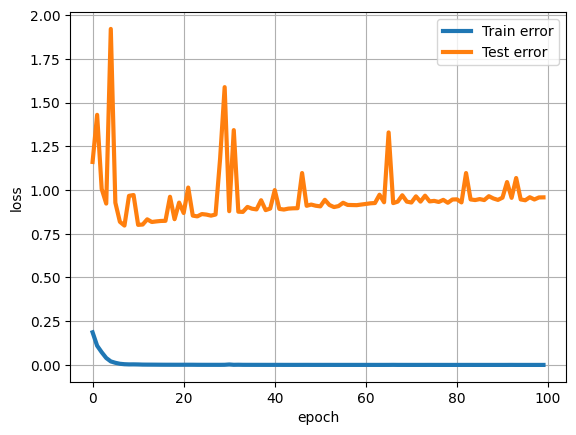

In [32]:
plt.plot(range(100),train_loss_history,'-',linewidth=3,label='Train error')
plt.plot(range(100),test_loss_history,'-',linewidth=3,label='Test error')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()
plt.show()

In [34]:
model.eval()
predictions = []
with torch.no_grad():
    for images in testDataLoader:
        images = images.to(device)
        images = torch.tensor(images, dtype=torch.float32)  # Convert NumPy array to PyTorch tensor
        images = images.permute(0, 3, 1, 2)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.cpu().numpy())

submission = pd.DataFrame({'ID': np.arange(len(predictions)), 'Labels': predictions})
submission.to_csv('/kaggle/working/submission.csv', index=False)
print("Submission file saved.")

<ipython-input-34-1c7382fe5c24>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  images = torch.tensor(images, dtype=torch.float32)  # Convert NumPy array to PyTorch tensor


Submission file saved.
